In [22]:
import os
import pandas as pd
import sqlite3
import statistics as stats
from scipy import stats as scipy_stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [23]:
# Figure aesthetics
sns.set_style('white')
sns.set_style('ticks')
sns.set_context("paper")

In [24]:
db_path = os.path.join(project_dir, 'database', 'sqlite-sakila.db')
db_connection = sqlite3.connect(db_path)

### Attention: must run src/visualization_view_queries.sql prior to running most of this notebook.

### Questions
1. Which film ratings are the most common? Which ratings of films are rented the most from store 1? Does the store 1 inventory reflect demand?
2. Which film categories are the most common? Which categories of films are rented the most from store 1? Does the store 1 inventory reflect demand?
3. What are the top 10 highest revenue generating films? Which actors have a role in more than 1 of these 10 films?
4. Is there a statistically significant difference in the average rental revenue of store 1 compared to store 2?

### Analyses and visualizations to answer these questions
- Run src/visualization_view_queries.sql to generate the views used to simplify the queries executed below.

### 1. Which film ratings are the most common? Which ratings of films are rented the most from store 1? Does the store 1 inventory reflect demand?

In [25]:
query = '''
SELECT
    rating, COUNT(rating) as rating_count
FROM
    film
GROUP BY
    rating
ORDER BY
    rating_count DESC;
'''
view = pd.read_sql_query(query, db_connection)
view
film_ratings_frequency = view['rating'].tolist()

,rating,rating_count
0,PG-13,223
1,NC-17,210
2,R,195
3,PG,194
4,G,178


In [26]:
query = '''
SELECT ri.rating as Rating, 
    'Inventory' as Data,
    100.0 * ri.rating_count / (SELECT SUM(rating_inventory_store_1_view.rating_count) FROM rating_inventory_store_1_view) as Percent
FROM rating_inventory_store_1_view AS ri
UNION
SELECT rir.rating as Rating, 
    'Rentals' as Data,
    100.0 * rir.rating_count / (SELECT SUM(rating_inventory_rental_store_1_view.rating_count) FROM rating_inventory_rental_store_1_view) as Percent
FROM rating_inventory_rental_store_1_view AS rir
'''
plot_view = pd.read_sql_query(query, db_connection)
plot_view

,Rating,Data,Percent
0,G,Inventory,17.356828
1,G,Rentals,17.379780
2,NC-17,Inventory,20.484581
3,NC-17,Rentals,20.509908
4,PG,Inventory,19.559471
5,PG,Rentals,19.373975
6,PG-13,Inventory,23.127753
7,PG-13,Rentals,23.337120
8,R,Inventory,19.471366
9,R,Rentals,19.399217


The most commmon film ratings (not film inventory) in descending order:
PG-13
NC-17
R
PG
G


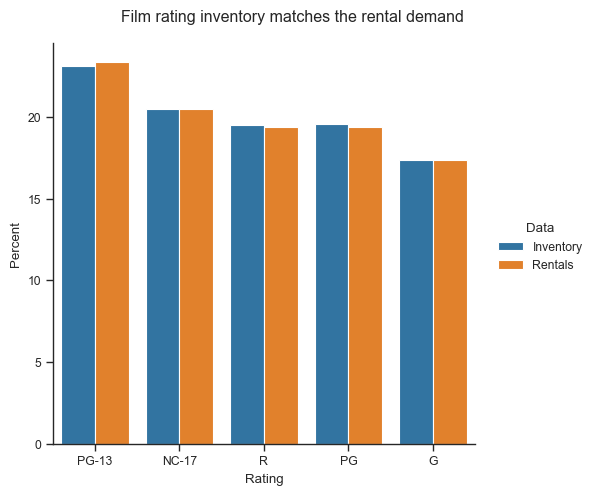

In [27]:
print('The most commmon film ratings (not film inventory) in descending order:')
for s in film_ratings_frequency:
    print(s)
g = sns.catplot(
    plot_view, kind='bar',
    x='Rating', y='Percent',
    hue='Data', order=film_ratings_frequency
)
g.figure.suptitle('Film rating inventory matches the rental demand')
g.tight_layout();

Film rating inventory seems to match the rental demand. 
- It is possible that the rental tendancies of customers are simply driven by inventory availability. 
- A more sophisticated analysis that examines how often films with specific ratings are on the shelf between customer rentals could lead to deeper insights.

### 2. Which film categories are the most common? Which categories of films are rented the most from store 1? Does the store 1 inventory reflect demand?

In [28]:
query = '''
SELECT
    c.name,
    COUNT(c.name) as category_count
FROM
    film as f
    JOIN film_category as fc
        ON f.film_id = fc.film_id
    JOIN category as c
        ON c.category_id = fc.category_id
GROUP BY
    c.name
ORDER BY
    category_count DESC;
'''
view = pd.read_sql_query(query, db_connection)
view
film_categories_frequency = view['name'].tolist()

,name,category_count
0,Sports,74
1,Foreign,73
2,Family,69
3,Documentary,68
4,Animation,66
5,Action,64
6,New,63
7,Drama,62
8,Sci-Fi,61
9,Games,61


In [29]:
query = '''
SELECT gi.category as Category,
    'Inventory' as Data,
    100.0 * gi.category_count / (SELECT SUM(category_inventory_store_1_view.category_count) FROM category_inventory_store_1_view) AS Percent
FROM category_inventory_store_1_view as gi
UNION
SELECT gir.category AS Category,
    'Rentals' AS Data,
    100.0 * gir.category_count / (SELECT SUM(category_inventory_rental_store_1_view.category_count) FROM category_inventory_rental_store_1_view) AS Percent
FROM category_inventory_rental_store_1_view as gir
'''
plot_view = pd.read_sql_query(query, db_connection)
plot_view

,Category,Data,Percent
0,Action,Inventory,7.444934
1,Action,Rentals,7.522403
2,Animation,Inventory,7.092511
3,Animation,Rentals,7.169002
4,Children,Inventory,5.682819
5,Children,Rentals,5.717531
6,Classics,Inventory,5.770925
7,Classics,Rentals,5.641802
8,Comedy,Inventory,6.255507
9,Comedy,Rentals,6.335984


The most commmon film categories (not film inventory) in descending order:
Sports
Foreign
Family
Documentary
Animation
Action
New
Drama
Sci-Fi
Games
Children
Comedy
Travel
Classics
Horror
Music


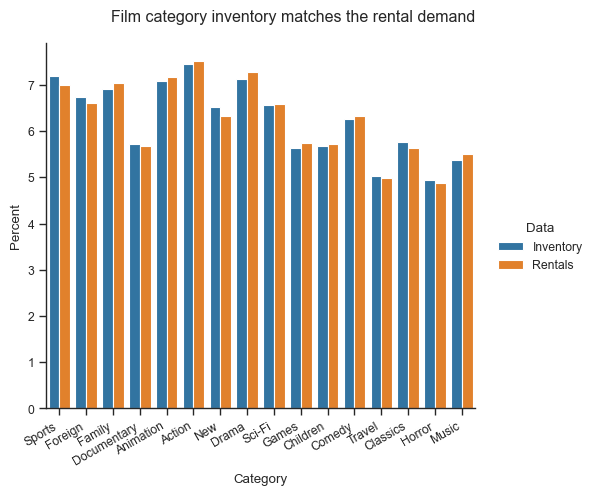

In [30]:
print('The most commmon film categories (not film inventory) in descending order:')
for s in film_categories_frequency:
    print(s)
g = sns.catplot(
    plot_view, kind='bar',
    x='Category', y='Percent',
    hue='Data', order=film_categories_frequency
)
g.figure.suptitle('Film category inventory matches the rental demand')
g.set_xticklabels(rotation=30, ha='right') 
g.tight_layout();

Film category matches the rental demand.
- It is possible that the rental tendancies of customers are simply driven by inventory availability. 
- A more sophisticated analysis that examines how often films with specific categories are on the shelf between customer rentals could lead to deeper insights.

### 3. What are the top 10 highest revenue generating films? Which actors have a role in more than 1 of these 10 films?

In [31]:
query = '''
SELECT * FROM top_revenue_film_view as t;
'''
view = pd.read_sql_query(query, db_connection)
view
top_10_films = view['title']

,film_id,title,revenue,average_payment,number_of_rentals
0,879,TELEGRAPH VOYAGE,231.73,8.582593,27
1,973,WIFE TURN,223.69,7.215806,31
2,1000,ZORRO ARK,214.69,6.925484,31
3,369,GOODFELLAS SALUTE,209.69,6.764194,31
4,764,SATURDAY LAMBS,204.72,7.311429,28
5,893,TITANS JERK,201.71,6.955517,29
6,897,TORQUE BOUND,198.72,7.360000,27
7,403,HARRY IDAHO,195.70,6.523333,30
8,460,INNOCENT USUAL,191.74,7.374615,26
9,444,HUSTLER PARTY,190.78,8.671818,22


In [32]:
query = '''
SELECT
    a.actors,
    COUNT(*) as number_of_film_appearances,
    SUM(t.revenue) as total_revenue,
    AVG(t.revenue) as average_revenue
FROM
    top_revenue_film_view as t
    JOIN actor_film_view as a
        ON t.film_id = a.film_id
GROUP BY
    a.actors
HAVING
    number_of_film_appearances > 1
ORDER BY
    total_revenue DESC;
'''
view = pd.read_sql_query(query, db_connection)
view
actors_with_multiple_roles = view['actors']

,actors,number_of_film_appearances,total_revenue,average_revenue
0,GINA DEGENERES,3,665.11,221.703333
1,WOODY HOFFMAN,2,455.42,227.710000
2,LUCILLE DEE,2,427.43,213.715000
3,CAMERON ZELLWEGER,2,419.39,209.695000
4,BEN WILLIS,2,414.41,207.205000
5,JAMES PITT,2,396.46,198.230000


In [33]:
print('Top 10 revenue generating films:')
for s in top_10_films:
    print(s)
print('\n')
print('Actors that have a role in more than 1 of these films:')
for s in actors_with_multiple_roles:
    print(s)

Top 10 revenue generating films:
TELEGRAPH VOYAGE
WIFE TURN
ZORRO ARK
GOODFELLAS SALUTE
SATURDAY LAMBS
TITANS JERK
TORQUE BOUND
HARRY IDAHO
INNOCENT USUAL
HUSTLER PARTY


Actors that have a role in more than 1 of these films:
GINA DEGENERES
WOODY HOFFMAN
LUCILLE DEE
CAMERON ZELLWEGER
BEN WILLIS
JAMES PITT


### 4. Is there a statistically significant difference in the average rental revenue of store 1 compared to store 2?

In [34]:
query = '''
SELECT
    i.store_id as Store,
    p.amount as Payment
FROM
    inventory as i
    JOIN rental as r
        ON i.inventory_id = r.inventory_id
    JOIN payment as p
        ON r.rental_id = p.rental_id;
'''
plot_view = pd.read_sql_query(query, db_connection)
plot_view.head()

,Store,Payment
0,2,2.99
1,2,0.99
2,1,5.99
3,2,0.99
4,1,9.99


In [35]:
print('overall stats')
plot_view['Payment'].describe()
store_1_payments = plot_view.loc[plot_view['Store']==1]['Payment'].to_list()
store_2_payments = plot_view.loc[plot_view['Store']==2]['Payment'].to_list()
print('store 1 mean')
stats.mean(store_1_payments)
print('store 2 mean')
stats.mean(store_2_payments)
ttest_result = scipy_stats.ttest_ind(
    store_1_payments,
    store_2_payments
    )
ttest_result

overall stats


count    16044.000000
mean         4.201356
std          2.362961
min          0.000000
25%          2.990000
50%          3.990000
75%          4.990000
max         11.990000
Name: Payment, dtype: float64

store 1 mean


4.2508885523160425

store 2 mean


4.153031646348972

TtestResult(statistic=2.623057691165757, pvalue=0.008722692873113317, df=16042.0)

In [36]:
# Modified from: https://stackoverflow.com/questions/67613774/how-to-add-a-mean-and-median-line-to-a-seaborn-displot
def specs(x, **kwargs):
    plt.axvline(x.mean(), c='blue', ls='-', lw=2.5)

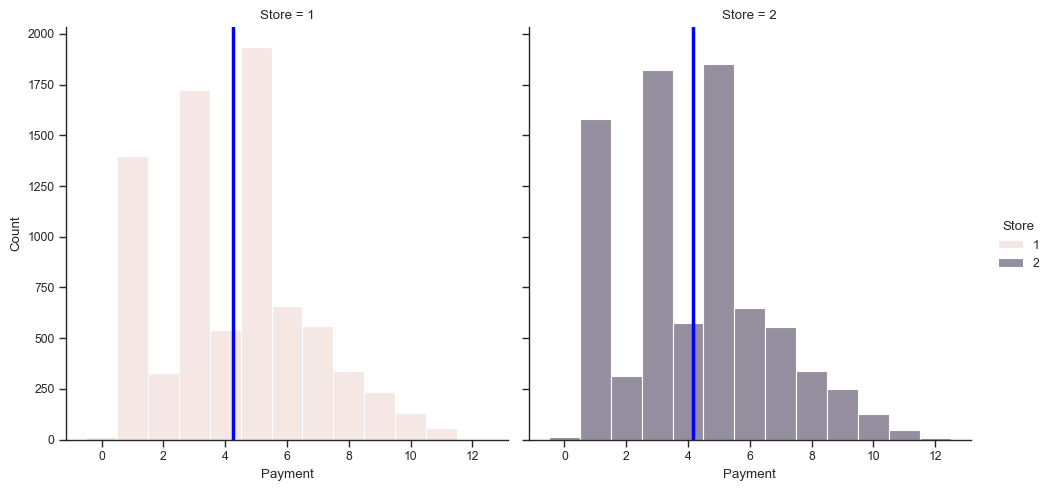

In [37]:
g = sns.displot(data=plot_view, x='Payment', hue='Store', col='Store', discrete=True)
g.map(specs,'Payment');

The t-test p-value < 0.05, so there is a significant difference between the mean rental revenue of store 1 compared to store 2. However, the difference between the means is small and by examining the plots we can see that the frequency of payment amounts is similiar. The mean payment value for each store is represented by a blue vertical line.